# Project : Augmenter ou diminuer le seuil de prédiction du clients mécontents pour augmenter la sensibilité des classifieurs

In [1]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics

In [2]:
#Chargement du fichier dataProjet.csv dans le dataframe df, n'oubliez pas de modifier le chemin 
#pour tenir compte de l'endroit ou se trouve votre fichier
df = pd.read_csv("dataProjet.csv")

In [3]:
# happy customers have TARGET==0, unhappy custormers have TARGET==1
# A little less then 4% are unhappy => unbalanced dataset
data = pd.DataFrame(df.TARGET.value_counts())
data['Percentage'] = 100*data['TARGET']/df.shape[0]
data

,TARGET,Percentage
0,73012,96.043147
1,3008,3.956853


<h3><span style="color: #3366ff;">Variable Identification</span></h3>
<p style="text-align: justify;">First, identify <strong>Predictor</strong> (Input) and <strong>Target</strong> (output) variables. Next, identify the data type and category of the variables.</p>

<p>
<ul>
    <li>Predictor : 
        <ul>
             <li>var3</li>
             <li>var15</li>
             <li>imp_ent_var16_ult1</li>
             <li>...</li>
        </ul>
    </li>
    <li>Target : &nbsp; TARGET
        <ul>
             <li>TARGET=0 &nbsp;:&nbsp; happy customers</li>
             <li>TARGET=1 &nbsp;:&nbsp; unhappy custormers</li>
        </ul>
    </li><br/>
    
    
</ul>
</p>

In [4]:
df.head(5)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


<h2><span style="color: #3366ff;">Nettoyage des données</span></h2>

In [5]:
#Colonne ID est non utile pour faire l'apprentissage, donc on le supprime
df.drop('ID', axis=1, inplace=True)
print "done"

done


<h3><span style="color: #03660f;"> Identifier les colonnes inutiles</span></h3>

In [6]:
#Identifier les colonnes inutiles (dont l'écart type est null)

Bruit=[]
for i in xrange(len(df.columns.values)):
    #pour chaque colonne "df[x]"
    if np.std(df[df.columns.values[i]]) == 0.0:
        #on recupère la liste des noms des colonnes "df.columns.values" et on la parcours
        Bruit.append(df.columns.values[i])
print 'Le nombre des colonnes inutiles est : ',len(Bruit)

#Les colonnes dont std = 0 , on va donc les supprimer parcequ'il est 
#n'apportera pas grand chose pour l'apprentissage (c'est que du bruit)

for i in xrange(len(Bruit)):
    df.drop(Bruit[i], axis=1, inplace=True)

print "done"

Le nombre des colonnes inutiles est :  34
done


In [7]:
def resemblance(column1 , column2):
    a = np.array(df[column1])
    b = np.array(df[column2])
    return ((a==b).sum() * 1.0)/len(a)

In [8]:
#la liste des colonnes
Liste=df.columns.values[:-1]
seuil=1.0

resemble=[]
jump = []
for i in xrange(len(Liste)):
    if i not in jump:
        for j in xrange(len(Liste)):
            if i!=j and resemblance(Liste[i], Liste[j]) >= seuil:
                if j not in jump:
                    #resemble.append(Liste[j])
                    jump.append(j)
    else:
        tempo=[]
        for j in xrange(len(Liste)):
            if i!=j and resemblance(Liste[i], Liste[j]) >= seuil:
                if j not in jump:
                    tempo.append(j)
        if len(tempo) >= 2:
            #resemble.extend(tempo[:-1])
            jump.extend(tempo[:-1])
print "Nombre des colonnes qui se ressemblent : ", len(jump)

def double(jump):
    proc = []
    doublons = []
    for r in jump:
         if r not in proc:
             proc.append(r)
         else:
             doublons.append(r)
    return doublons

#Delete les colonnes dont les valeurs se ressemblent
if len(double(jump))==0:
    for i in xrange(len(jump)):
        df.drop([Liste[jump[i]]], axis=1, inplace=True)
        resemble.append(Liste[jump[i]])
    print "..... droped"
else:
    print "ERROR..."


print "done"

Nombre des colonnes qui se ressemblent :  29
..... droped
done


In [9]:
import seaborn as sns
cor_mat = df.iloc[:,:-1].corr()

# only important correlations and not auto-correlations
threshold = 0.95
important_corrs = (cor_mat[abs(cor_mat) > threshold][cor_mat != 1.0]) \
    .unstack().dropna().to_dict()
unique_important_corrs = pd.DataFrame(
    list(set([(tuple(sorted(key)), important_corrs[key]) \
    for key in important_corrs])), columns=['attribute pair', 'correlation'])
# sorted by absolute value
unique_important_corrs = unique_important_corrs.ix[
    abs(unique_important_corrs['correlation']).argsort()[::-1]]
unique_important_corrs

,attribute pair,correlation
117,"(ind_var6, num_var6)",1.000000
85,"(delta_imp_trasp_var33_out_1y3, num_trasp_var3...",1.000000
87,"(delta_imp_reemb_var33_1y3, num_reemb_var33_ult1)",1.000000
115,"(ind_var20_0, num_var20_0)",1.000000
110,"(delta_imp_reemb_var13_1y3, num_reemb_var13_ult1)",1.000000
81,"(ind_var20, num_var20)",1.000000
67,"(ind_var13_medio_0, num_var13_medio_0)",1.000000
27,"(num_meses_var13_medio_ult3, num_var13_medio_0)",1.000000
28,"(delta_imp_amort_var18_1y3, num_var18_0)",1.000000
32,"(ind_var18_0, num_var18_0)",1.000000


In [10]:
resemblance("ind_var6", "num_var6")

0.9999736911339121

In [11]:
#la liste des colonnes
Liste=df.columns.values[:-1]
seuil=0.99

resemble=[]
jump = []
for i in xrange(len(Liste)):
    if i not in jump:
        for j in xrange(len(Liste)):
            if i!=j and resemblance(Liste[i], Liste[j]) >= seuil:
                if j not in jump:
                    #resemble.append(Liste[j])
                    jump.append(j)
    else:
        tempo=[]
        for j in xrange(len(Liste)):
            if i!=j and resemblance(Liste[i], Liste[j]) >= seuil:
                if j not in jump:
                    tempo.append(j)
        if len(tempo) >= 2:
            #resemble.extend(tempo[:-1])
            jump.extend(tempo[:-1])
print "Nombre des colonnes qui se ressemblent : ", len(jump)

def double(jump):
    proc = []
    doublons = []
    for r in jump:
         if r not in proc:
             proc.append(r)
         else:
             doublons.append(r)
    return doublons

#Delete les colonnes dont les valeurs se ressemblent
if len(double(jump))==0:
    for i in xrange(len(jump)):
        df.drop([Liste[jump[i]]], axis=1, inplace=True)
        resemble.append(Liste[jump[i]])
    print "..... droped"
else:
    print "ERROR..."


print "done"

Nombre des colonnes qui se ressemblent :  202
..... droped
done


In [12]:
print " Le nombre des variables restante est: ",len(df.columns.values)

 Le nombre des variables restante est:  105


,attribute pair,correlation
12,"(ind_var8_0, num_var8_0)",0.999793
3,"(ind_var1_0, num_var1_0)",0.998849
10,"(num_med_var45_ult3, num_var45_ult3)",0.997806
4,"(ind_var24_0, num_var24_0)",0.997448
7,"(ind_var5, num_var5)",0.993709
5,"(saldo_medio_var12_ult1, saldo_var12)",0.986397
15,"(saldo_medio_var12_ult1, saldo_medio_var12_ult3)",0.985940
6,"(num_var35, num_var4)",0.983125
0,"(saldo_medio_var13_corto_ult3, saldo_var13_corto)",0.980455
9,"(saldo_var12, saldo_var42)",0.978415


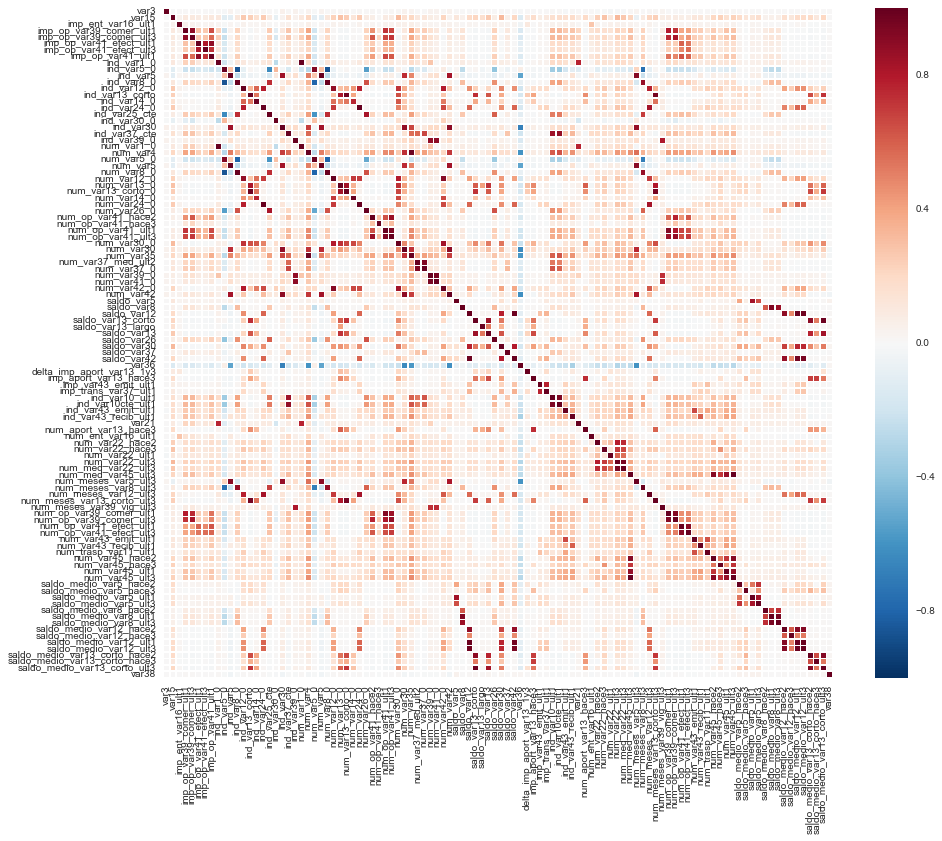

In [13]:
cor_mat = df.iloc[:,:-1].corr()

f, ax = plt.subplots(figsize=(15, 12))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cor_mat,linewidths=.5, ax=ax);

# only important correlations and not auto-correlations
threshold = 0.95
important_corrs = (cor_mat[abs(cor_mat) > threshold][cor_mat != 1.0]) \
    .unstack().dropna().to_dict()
unique_important_corrs = pd.DataFrame(
    list(set([(tuple(sorted(key)), important_corrs[key]) \
    for key in important_corrs])), columns=['attribute pair', 'correlation'])
# sorted by absolute value
unique_important_corrs = unique_important_corrs.ix[
    abs(unique_important_corrs['correlation']).argsort()[::-1]]
unique_important_corrs

In [44]:
import re

for col in df.columns.values:
    i=0
    ch=0
    for val in df[col]:
        if re.search("^-?9{4,20}", str(val)):
            i=i+1
            ch=val
    if i!=0:
        print col , ch ,i
            

var3 -999999 116
delta_imp_aport_var13_1y3 9999999999.0 370
saldo_medio_var5_hace2 9999.93 4
saldo_medio_var5_hace3 9999.99 4
saldo_medio_var12_ult3 9999.09 1
saldo_medio_var13_corto_hace2 99999.99 4
saldo_medio_var13_corto_hace3 9999.99 7
saldo_medio_var13_corto_ult3 99999.99 3
var38 99991.38 1


In [47]:
#Valeurs les plus communes
df.var3.value_counts()[:10]

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64

In [46]:
#Valeurs les plus communes
df.delta_imp_aport_var13_1y3.value_counts()

 0.000000e+00    73948
-1.000000e+00     1675
 1.000000e+10      370
-5.000000e-01        2
 4.000000e+00        2
-3.333333e-01        2
-4.995000e-01        1
 4.000000e-01        1
 1.000000e+00        1
-8.333333e-01        1
-8.000000e-01        1
-2.910826e-01        1
 2.333092e+00        1
-1.000000e-01        1
 1.538462e-01        1
 1.222222e+00        1
-9.038462e-01        1
-9.090909e-02        1
 5.500000e+00        1
 1.181818e+00        1
 1.605039e-01        1
-1.973684e-01        1
 1.777778e+00        1
-6.666667e-01        1
-7.602877e-01        1
 1.445714e+00        1
-3.494898e-01        1
Name: delta_imp_aport_var13_1y3, dtype: int64

In [14]:
# 116 valeurs dans la colonne var3 sont -999999.
# - 999999 signifierait que la vrai valeur est inconnue

print df.loc[df.var3==-999999].shape

# Remplacez -999999 dans la colonne var3 avec la valeur la plus commune 2

df = df.replace(-999999,2)
print df.loc[df.var3==-999999].shape

(116, 105)
(0, 105)


In [15]:
print df.columns.values

['var3' 'var15' 'imp_ent_var16_ult1' 'imp_op_var39_comer_ult1'
 'imp_op_var39_comer_ult3' 'imp_op_var41_efect_ult1'
 'imp_op_var41_efect_ult3' 'imp_op_var41_ult1' 'ind_var1_0' 'ind_var5_0'
 'ind_var5' 'ind_var8_0' 'ind_var12_0' 'ind_var13_corto' 'ind_var14_0'
 'ind_var24_0' 'ind_var25_cte' 'ind_var30_0' 'ind_var30' 'ind_var37_cte'
 'ind_var39_0' 'num_var1_0' 'num_var4' 'num_var5_0' 'num_var5' 'num_var8_0'
 'num_var12_0' 'num_var13_0' 'num_var13_corto_0' 'num_var14_0'
 'num_var24_0' 'num_var26_0' 'num_op_var41_hace2' 'num_op_var41_hace3'
 'num_op_var41_ult1' 'num_op_var41_ult3' 'num_var30_0' 'num_var30'
 'num_var35' 'num_var37_med_ult2' 'num_var37_0' 'num_var39_0' 'num_var41_0'
 'num_var42_0' 'num_var42' 'saldo_var5' 'saldo_var8' 'saldo_var12'
 'saldo_var13_corto' 'saldo_var13_largo' 'saldo_var13' 'saldo_var26'
 'saldo_var30' 'saldo_var37' 'saldo_var42' 'var36'
 'delta_imp_aport_var13_1y3' 'imp_aport_var13_hace3' 'imp_var43_emit_ult1'
 'imp_trans_var37_ult1' 'ind_var10_ult1' 'ind_var10c

## Echantillonnage de données

In [16]:
train=df.head(int(df.TARGET.shape[0]*0.8))
test=df.tail(int(df.TARGET.shape[0]*0.2))

df1 = pd.DataFrame(train.TARGET.value_counts())
df1['Percentage'] = 100*df1['TARGET']/train.shape[0]
print 'train \n\n',df1

Y = train.TARGET
X = train.drop(['TARGET'], axis=1)



df2 = pd.DataFrame(test.TARGET.value_counts())
df2['Percentage'] = 100*df2['TARGET']/test.shape[0]
print '\n\ntest \n\n',df2

YValid = test.TARGET
XValid = test.drop(['TARGET'], axis=1)

train 

   TARGET  Percentage
0   58468   96.139174
1    2348    3.860826


test 

   TARGET  Percentage
0   14544   95.659037
1     660    4.340963


In [18]:
# diviser X et Y en training and testing
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25,random_state=1)

df1 = pd.DataFrame(Y_train.value_counts())
df1['Percentage'] = 100*df1['TARGET']/len(Y_train)
pr1=100*len(Y_train)/60816.0
print 'train ',pr1,'%\n\n', df1

df2 = pd.DataFrame(Y_test.value_counts())
df2['Percentage'] = 100*df2['TARGET']/len(Y_test)
pr2=100*len(Y_test)/60816.0
print '\n\ntest',pr2,'% \n\n',df2

 train  75.0 %

   TARGET  Percentage
0   43848   96.132597
1    1764    3.867403


test 25.0 % 

   TARGET  Percentage
0   14620   96.158906
1     584    3.841094


<h3><span style="color: #3366ff;">CHOIX DU MODELE A UTILISER</span></h3>

In [25]:
#fonction de prédiction sur le dataset de validation
def validation(clf1, Xv, Yv):
    preds = clf1.predict_proba(Xv)[:,1]
    return roc_auc_score(Yv, preds)

#fonction de prédiction avec seuil sur le dataset de validation
def validation_Seuil(clf1, Xv, Yv, seuil):
    preds = clf1.predict_proba(Xv)[:,1]
    preds_class = np.array(preds>(seuil+0.0), dtype=int)
    return roc_auc_score(Yv, preds_class)


Selected features :  ['var15', 'ind_var30', 'saldo_var30', 'saldo_medio_var5_ult3', 'var38', 'num_meses_var5_ult3', 'num_var35']
scoreTrain =  0.814983192478    pramas =  {'max_depth': 6, 'min_samples_leaf': 4}

## Arbres de décision

In [175]:
#Les arbres de décision

RandomForestSelection=['var15', 'ind_var30', 'saldo_var30', 'saldo_medio_var5_ult3', 'var38', 'num_meses_var5_ult3', 'num_var35']
modele_1 = DecisionTreeClassifier(random_state=1, max_depth=6, min_samples_leaf=4)
modele_1.fit(X_train[RandomForestSelection],Y_train)



DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

In [176]:
print "train",validation(modele_1, X_train[RandomForestSelection], Y_train)
print "test",validation(modele_1, X_test[RandomForestSelection], Y_test)

train 0.840567313862
test 0.809983567734


### Resultat d'analyse

Matrice de Confusion
       0  1
0  14616  4
1    583  1


Taux de prédiction (accuracy):  0.961391739016
Sensibilité :  0.00171232876712
Precision : 0.2
Spécificité : 0.999726402189 

roc_auc_score =  0.809983567734


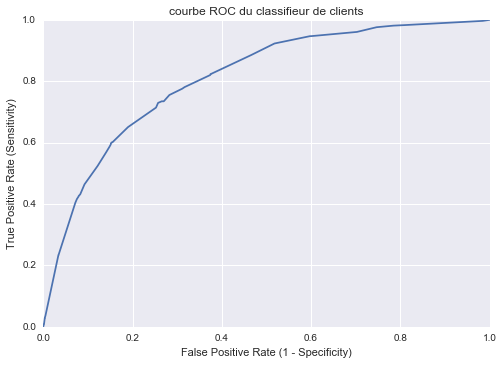

In [177]:
Model=modele_1

# On prédit pour les données de test
y_pred_class = Model.predict(X_test[RandomForestSelection])

# on stocke la matrice de confusion et on récupère les TP, TN, FP, FN
confusion = metrics.confusion_matrix(Y_test, y_pred_class)

tp = confusion[1, 1]
tn = confusion[0, 0]
fp = confusion[0, 1]
fn = confusion[1, 0]

print "Matrice de Confusion"
matrix = pd.DataFrame([confusion[0][0],confusion[1][0]])
matrix['1'] = [confusion[0][1],confusion[1][1]]
print  matrix

print "\n\nTaux de prédiction (accuracy): ",(tp + tn) / float(tp + tn + fp + fn)
print "Sensibilité : ",tp / float(tp + fn)
print"Precision :", tp / float(tp + fp)
print"Spécificité :", tn / float(tn + fp),"\n"

# on stocke les degrés d'appartenance pour la classe 1
y_pred_prob = Model.predict_proba(X_test[RandomForestSelection])[:, 1]


fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('courbe ROC du classifieur de clients')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print "roc_auc_score = ", metrics.roc_auc_score(Y_test, y_pred_prob)

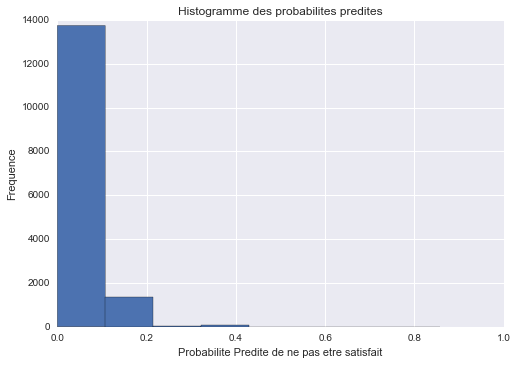

In [178]:
# histogramme des probabilités prédites
plt.hist(y_pred_prob, bins=8)
plt.xlim(0, 1)
plt.title('Histogramme des probabilites predites')
plt.xlabel('Probabilite Predite de ne pas etre satisfait' )
plt.ylabel('Frequence')

**Diminuer** le seuil de prédiction du clients mécontents pour **augmenter** la sensitivity du classifieur

### Resultat avec le seuil choisi

Resultat de validation (sans seuil) :  0.809983567734
roc_auc_score (avec seuil =  0.08 ) =  0.713795138954


 Matrice de confusion
[[12560  2060]
 [  252   332]]

Sensibilité =  0.568493150685
Spécificité  0.859097127223


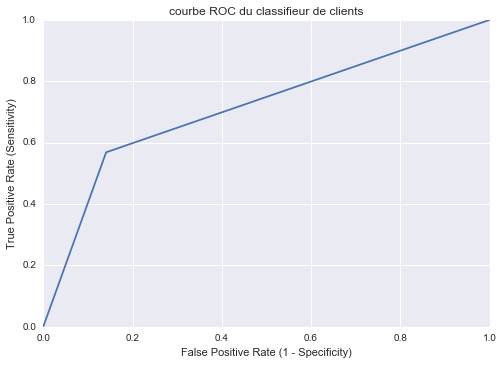

In [179]:
Model= modele_1
seuil= 0.08

print "Resultat de validation (sans seuil) : ",validation(Model, X_test[RandomForestSelection], Y_test)

# on stocke les degrés d'appartenance pour la classe 1
yTest_pred_prob = Model.predict_proba(X_test[RandomForestSelection])[:, 1]

# Predire un client mécontent si la probabilité prédite est supérieure à le seuil
yTest_pred_class = np.array(yTest_pred_prob>seuil, dtype=int)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, yTest_pred_class)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('courbe ROC du classifieur de clients')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print "roc_auc_score (avec seuil = ",seuil,") = ", metrics.roc_auc_score(Y_test, yTest_pred_class)


# nouvelle matrice de confusion (avec seuil)
matCorr = metrics.confusion_matrix(Y_test, yTest_pred_class)

TP = matCorr[1, 1]
TN = matCorr[0, 0]
FP = matCorr[0, 1]
FN = matCorr[1, 0]

print "\n\n Matrice de confusion\n",matCorr

# la sensitivity a augmenté
print"\nSensibilité = ", TP / float(TP + FN)

# la spécificité a diminué
print"Spécificité ", TN / float(TN + FP)

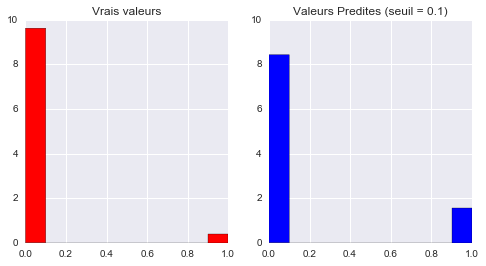

In [180]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
_=plt.hist(Y_test.values, color='red', normed=True)
plt.title('Vrais valeurs')
_=plt.ylim(0,10)
plt.subplot(1,2,2)
_=plt.hist(yTest_pred_class, color ='blue',  normed=True)
plt.title('Valeurs Predites (seuil = 0.1)')
_=plt.ylim(0,10)

<br/><br/><br/>

## AdaBoostClassifier

In [160]:
from sklearn.ensemble import AdaBoostClassifier
modele_2 = AdaBoostClassifier(n_estimators=60, random_state=1)
modele_2.fit(X_train[RandomForestSelection], Y_train)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=60, random_state=1)

In [161]:
print "train",validation(modele_2, X_train[RandomForestSelection], Y_train)
print "test",validation(modele_2, X_test[RandomForestSelection], Y_test)

train 0.835155135231
test 0.820931696588


### Resultat d'analyse

Matrice de Confusion
       0  1
0  14620  0
1    583  1


Taux de prédiction (accuracy):  0.961654827677
Sensibilité :  0.00171232876712
Precision : 1.0
Spécificité : 1.0 

roc_auc_score =  0.820931696588


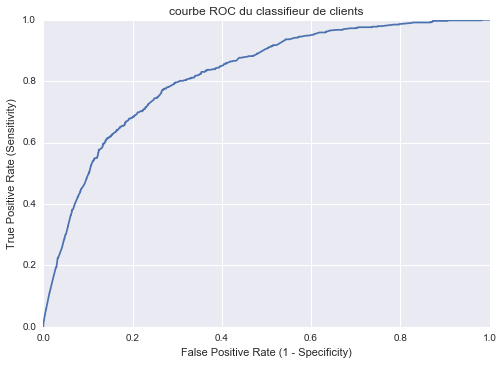

In [162]:
Model=modele_2

# On prédit pour les données de test
y_pred_class = Model.predict(X_test[RandomForestSelection])

# on stocke la matrice de confusion et on récupère les TP, TN, FP, FN
confusion = metrics.confusion_matrix(Y_test, y_pred_class)

tp = confusion[1, 1]
tn = confusion[0, 0]
fp = confusion[0, 1]
fn = confusion[1, 0]

print "Matrice de Confusion"
matrix = pd.DataFrame([confusion[0][0],confusion[1][0]])
matrix['1'] = [confusion[0][1],confusion[1][1]]
print  matrix

print "\n\nTaux de prédiction (accuracy): ",(tp + tn) / float(tp + tn + fp + fn)
print "Sensibilité : ",tp / float(tp + fn)
print"Precision :", tp / float(tp + fp)
print"Spécificité :", tn / float(tn + fp),"\n"

# on stocke les degrés d'appartenance pour la classe 1
y_pred_prob = Model.predict_proba(X_test[RandomForestSelection])[:, 1]


fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('courbe ROC du classifieur de clients')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print "roc_auc_score = ", metrics.roc_auc_score(Y_test, y_pred_prob)

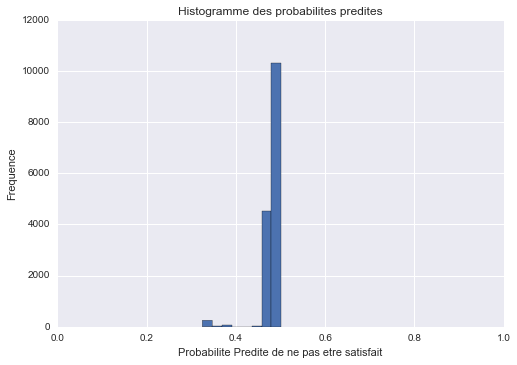

In [163]:
# histogramme des probabilités prédites
plt.hist(y_pred_prob, bins=8)
plt.xlim(0, 1)
plt.title('Histogramme des probabilites predites')
plt.xlabel('Probabilite Predite de ne pas etre satisfait' )
plt.ylabel('Frequence')

**Diminuer** le seuil de prédiction du clients mécontents pour **augmenter** la sensitivity du classifieur

### Resultat avec le seuil choisi

Resultat de validation (sans seuil) :  0.820931696588
roc_auc_score (avec seuil =  0.49 ) =  0.729406611322


 Matrice de confusion
[[12666  1954]
 [  238   346]]

Sensibilité =  0.592465753425
Spécificité  0.86634746922


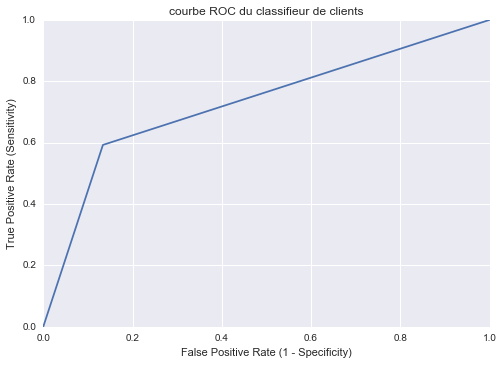

In [164]:
Model= modele_2
seuil= 0.49

print "Resultat de validation (sans seuil) : ",validation(Model, X_test[RandomForestSelection], Y_test)

# on stocke les degrés d'appartenance pour la classe 1
yTest_pred_prob = Model.predict_proba(X_test[RandomForestSelection])[:, 1]

# Predire un client mécontent si la probabilité prédite est supérieure à le seuil
yTest_pred_class = np.array(yTest_pred_prob>seuil, dtype=int)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, yTest_pred_class)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('courbe ROC du classifieur de clients')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print "roc_auc_score (avec seuil = ",seuil,") = ", metrics.roc_auc_score(Y_test, yTest_pred_class)


# nouvelle matrice de confusion (avec seuil)
matCorr = metrics.confusion_matrix(Y_test, yTest_pred_class)

TP = matCorr[1, 1]
TN = matCorr[0, 0]
FP = matCorr[0, 1]
FN = matCorr[1, 0]

print "\n\n Matrice de confusion\n",matCorr

# la sensitivity a augmenté
print"\nSensibilité = ", TP / float(TP + FN)

# la spécificité a diminué
print"Spécificité ", TN / float(TN + FP)

## GradientBoostingClassifier

In [128]:
from sklearn.ensemble import GradientBoostingClassifier
modele_3 = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=1, random_state=1).fit(X_train[RandomForestSelection], Y_train)

In [132]:
print "Validation = ",validation(modele_3, X_test[RandomForestSelection], Y_test)

Validation =  0.813962916721


### Resultat d'analyse

Matrice de Confusion
       0  1
0  14620  0
1    582  2


Taux de prédiction (accuracy):  0.961720599842
Sensibilité :  0.00342465753425
Precision : 1.0
Spécificité : 1.0 

roc_auc_score =  0.813962916721


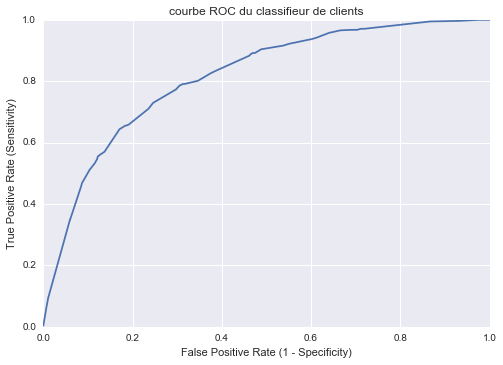

In [135]:
Model=modele_3

# On prédit pour les données de test
y_pred_class = Model.predict(X_test[RandomForestSelection])

# on stocke la matrice de confusion et on récupère les TP, TN, FP, FN
confusion = metrics.confusion_matrix(Y_test, y_pred_class)

tp = confusion[1, 1]
tn = confusion[0, 0]
fp = confusion[0, 1]
fn = confusion[1, 0]

print "Matrice de Confusion"
matrix = pd.DataFrame([confusion[0][0],confusion[1][0]])
matrix['1'] = [confusion[0][1],confusion[1][1]]
print  matrix

print "\n\nTaux de prédiction (accuracy): ",(tp + tn) / float(tp + tn + fp + fn)
print "Sensibilité : ",tp / float(tp + fn)
print"Precision :", tp / float(tp + fp)
print"Spécificité :", tn / float(tn + fp),"\n"

# on stocke les degrés d'appartenance pour la classe 1
y_pred_prob = Model.predict_proba(X_test[RandomForestSelection])[:, 1]


fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('courbe ROC du classifieur de clients')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print "roc_auc_score = ", metrics.roc_auc_score(Y_test, y_pred_prob)

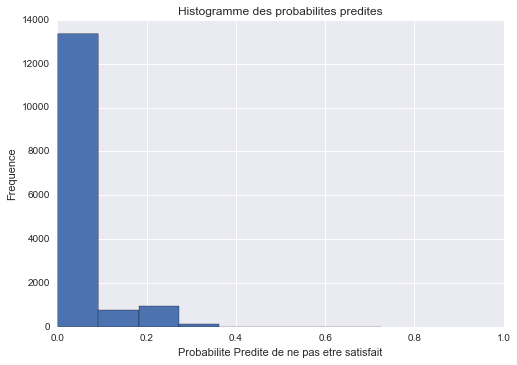

In [136]:
# histogramme des probabilités prédites
plt.hist(y_pred_prob, bins=8)
plt.xlim(0, 1)
plt.title('Histogramme des probabilites predites')
plt.xlabel('Probabilite Predite de ne pas etre satisfait' )
plt.ylabel('Frequence')

**Diminuer** le seuil de prédiction du clients mécontents pour **augmenter** la sensitivity du classifieur

### Resultat avec le seuil choisi

Resultat de validation (sans seuil) :  0.813962916721
roc_auc_score (avec seuil =  0.05 ) =  0.73645269194


 Matrice de confusion
[[12121  2499]
 [  208   376]]

Sensibilité =  0.643835616438
Spécificité  0.829069767442


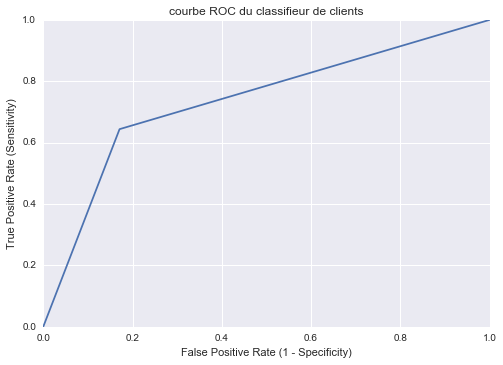

In [144]:
Model= modele_3
seuil= 0.05

print "Resultat de validation (sans seuil) : ",validation(Model, X_test[RandomForestSelection], Y_test)

# on stocke les degrés d'appartenance pour la classe 1
yTest_pred_prob = Model.predict_proba(X_test[RandomForestSelection])[:, 1]

# Predire un client mécontent si la probabilité prédite est supérieure à le seuil
yTest_pred_class = np.array(yTest_pred_prob>seuil, dtype=int)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, yTest_pred_class)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('courbe ROC du classifieur de clients')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print "roc_auc_score (avec seuil = ",seuil,") = ", metrics.roc_auc_score(Y_test, yTest_pred_class)


# nouvelle matrice de confusion (avec seuil)
matCorr = metrics.confusion_matrix(Y_test, yTest_pred_class)

TP = matCorr[1, 1]
TN = matCorr[0, 0]
FP = matCorr[0, 1]
FN = matCorr[1, 0]

print "\n\n Matrice de confusion\n",matCorr

# la sensitivity a augmenté
print"\nSensibilité = ", TP / float(TP + FN)

# la spécificité a diminué
print"Spécificité ", TN / float(TN + FP)

## Regression logistique [LASSO Selection]

In [152]:
LassoFeaturesSelection = ['var15', 'num_var5', 'ind_var8_0', 'ind_var30_0', 'num_var22_ult1', 'num_op_var41_efect_ult3', 'num_meses_var12_ult3', 'num_meses_var39_vig_ult3', 'imp_op_var39_comer_ult1', 'var36', 'imp_op_var41_ult1', 'imp_op_var41_efect_ult1', 'num_ent_var16_ult1', 'ind_var1_0', 'num_var45_ult1', 'num_var22_hace2', 'num_med_var22_ult3', 'imp_var43_emit_ult1', 'num_op_var41_hace2', 'saldo_medio_var12_hace2', 'ind_var10_ult1', 'num_var45_hace3', 'num_var42_0', 'num_var14_0', 'delta_imp_aport_var13_1y3', 'num_var13_corto_0', 'saldo_var37', 'ind_var25_cte', 'saldo_medio_var13_corto_hace2', 'num_var45_ult3', 'saldo_medio_var5_hace3', 'saldo_medio_var8_hace2', 'num_op_var39_comer_ult3', 'saldo_var42', 'saldo_var13_corto', 'saldo_var12', 'saldo_medio_var8_ult3', 'saldo_medio_var13_corto_ult3', 'saldo_medio_var12_ult3', 'saldo_medio_var12_ult1', 'num_var8_0', 'num_var5_0', 'num_var45_hace2', 'num_var43_emit_ult1', 'num_var41_0', 'num_var37_0', 'num_var35', 'num_var30_0', 'num_var30', 'num_var26_0', 'num_var24_0', 'num_var22_ult3', 'num_var1_0', 'num_var12_0', 'num_trasp_var11_ult1', 'num_op_var41_ult3', 'num_op_var41_efect_ult1', 'num_op_var39_comer_ult1', 'num_meses_var13_corto_ult3', 'num_med_var45_ult3']

In [153]:
# on va apprendre un modèle de régression logistique
from sklearn.linear_model import LogisticRegression
modele_4 = LogisticRegression(random_state=1,n_jobs=2)
modele_4.fit(X_train[LassoFeaturesSelection], Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=2,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [155]:
print "Validation = ",validation(modele_4, X_test[LassoFeaturesSelection], Y_test)

Validation =  0.549030461181


### Resultat d'analyse

Matrice de Confusion
       0  1
0  14614  6
1    579  5


Taux de prédiction (accuracy):  0.961523283346
Sensibilité :  0.00856164383562
Precision : 0.454545454545
Spécificité : 0.999589603283 

roc_auc_score =  0.549030461181


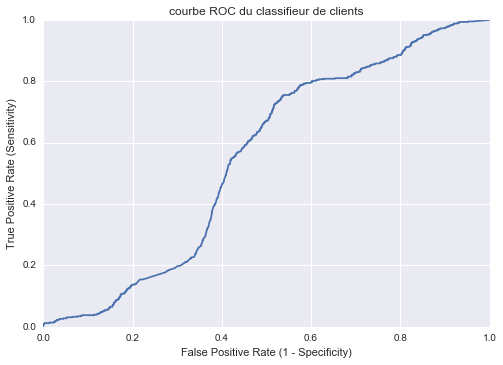

In [154]:
Model=modele_4

# On prédit pour les données de test
y_pred_class = Model.predict(X_test[LassoFeaturesSelection])

# on stocke la matrice de confusion et on récupère les TP, TN, FP, FN
confusion = metrics.confusion_matrix(Y_test, y_pred_class)

tp = confusion[1, 1]
tn = confusion[0, 0]
fp = confusion[0, 1]
fn = confusion[1, 0]

print "Matrice de Confusion"
matrix = pd.DataFrame([confusion[0][0],confusion[1][0]])
matrix['1'] = [confusion[0][1],confusion[1][1]]
print  matrix

print "\n\nTaux de prédiction (accuracy): ",(tp + tn) / float(tp + tn + fp + fn)
print "Sensibilité : ",tp / float(tp + fn)
print"Precision :", tp / float(tp + fp)
print"Spécificité :", tn / float(tn + fp),"\n"

# on stocke les degrés d'appartenance pour la classe 1
y_pred_prob = Model.predict_proba(X_test[LassoFeaturesSelection])[:, 1]


fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('courbe ROC du classifieur de clients')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print "roc_auc_score = ", metrics.roc_auc_score(Y_test, y_pred_prob)

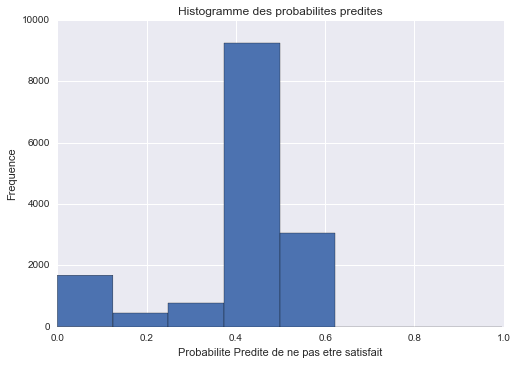

In [156]:
# histogramme des probabilités prédites
plt.hist(y_pred_prob, bins=8)
plt.xlim(0, 1)
plt.title('Histogramme des probabilites predites')
plt.xlabel('Probabilite Predite de ne pas etre satisfait' )
plt.ylabel('Frequence')

**Diminuer** le seuil de prédiction du clients mécontents pour **augmenter** la sensitivity du classifieur

### Resultat avec le seuil choisi

 Resultat de validation (sans seuil) :  0.549030461181
roc_auc_score (avec seuil =  0.49 ) =  0.598632947923


 Matrice de confusion
[[5788 8832]
 [ 116  468]]

Sensibilité =  0.801369863014
Spécificité  0.395896032832


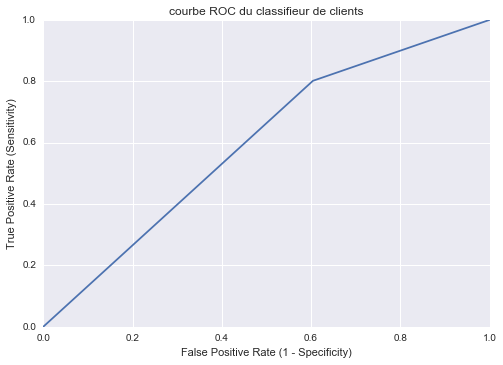

In [158]:
Model= modele_4
seuil= 0.49

print "Resultat de validation (sans seuil) : ",validation(Model, X_test[LassoFeaturesSelection], Y_test)

# on stocke les degrés d'appartenance pour la classe 1
yTest_pred_prob = Model.predict_proba(X_test[LassoFeaturesSelection])[:, 1]

# Predire un client mécontent si la probabilité prédite est supérieure à le seuil
yTest_pred_class = np.array(yTest_pred_prob>seuil, dtype=int)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, yTest_pred_class)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('courbe ROC du classifieur de clients')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print "roc_auc_score (avec seuil = ",seuil,") = ", metrics.roc_auc_score(Y_test, yTest_pred_class)


# nouvelle matrice de confusion (avec seuil)
matCorr = metrics.confusion_matrix(Y_test, yTest_pred_class)

TP = matCorr[1, 1]
TN = matCorr[0, 0]
FP = matCorr[0, 1]
FN = matCorr[1, 0]

print "\n\n Matrice de confusion\n",matCorr

# la sensitivity a augmenté
print"\nSensibilité = ", TP / float(TP + FN)

# la spécificité a diminué
print"Spécificité ", TN / float(TN + FP)

# Soft VotingClassifier

In [410]:
from itertools import product
from sklearn.ensemble import VotingClassifier

# Training classifiers
clf1 = modele_1
clf2 = modele_2
clf3 = modele_3
clf4 = modele_4
eclf = VotingClassifier(estimators=[('dt', clf1), ('abc', clf2), ('gbc', clf3), ('rl', clf4)], voting='soft', 
                        weights=[3,3,2,1])

eclf = eclf.fit(X_train,Y_train)

In [411]:
print "Validation = ",validation(eclf, X_test, Y_test)

Validation =  0.820448801136


### Resultat d'analyse

Matrice de Confusion
       0  1
0  14619  1
1    582  2


Taux de prédiction (accuracy):  0.961654827677
Sensibilité :  0.00342465753425
Precision : 0.666666666667
Spécificité : 0.999931600547 

roc_auc_score =  0.820448801136


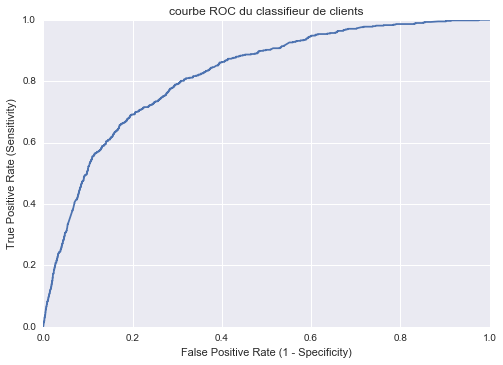

In [412]:
Model=eclf

# On prédit pour les données de test
y_pred_class = Model.predict(X_test)

# on stocke la matrice de confusion et on récupère les TP, TN, FP, FN
confusion = metrics.confusion_matrix(Y_test, y_pred_class)

tp = confusion[1, 1]
tn = confusion[0, 0]
fp = confusion[0, 1]
fn = confusion[1, 0]

print "Matrice de Confusion"
matrix = pd.DataFrame([confusion[0][0],confusion[1][0]])
matrix['1'] = [confusion[0][1],confusion[1][1]]
print  matrix

print "\n\nTaux de prédiction (accuracy): ",(tp + tn) / float(tp + tn + fp + fn)
print "Sensibilité : ",tp / float(tp + fn)
print"Precision :", tp / float(tp + fp)
print"Spécificité :", tn / float(tn + fp),"\n"

# on stocke les degrés d'appartenance pour la classe 1
y_pred_prob = Model.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('courbe ROC du classifieur de clients')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print "roc_auc_score = ", metrics.roc_auc_score(Y_test, y_pred_prob)

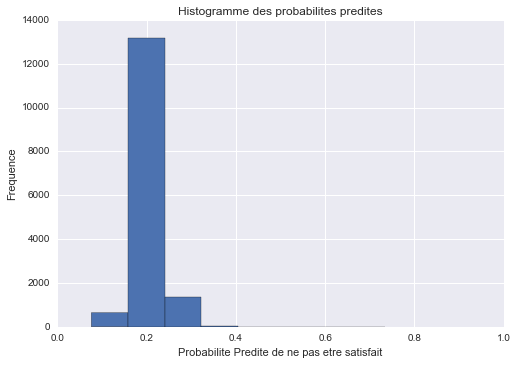

In [413]:
# histogramme des probabilités prédites
plt.hist(y_pred_prob, bins=8)
plt.xlim(0, 1)
plt.title('Histogramme des probabilites predites')
plt.xlabel('Probabilite Predite de ne pas etre satisfait' )
plt.ylabel('Frequence')

Resultat de validation (sans seuil) :  0.820448801136
roc_auc_score (avec seuil =  0.19 ) =  0.74100664318


 Matrice de confusion
[[10677  3943]
 [  145   439]]

Sensibilité =  0.751712328767
Spécificité  0.730300957592


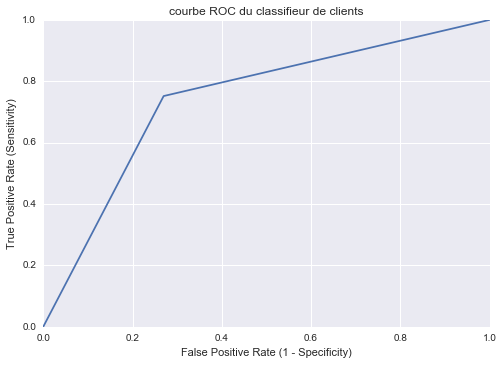

In [414]:
Model= eclf
seuil= 0.19

print "Resultat de validation (sans seuil) : ",validation(Model, X_test, Y_test)

# on stocke les degrés d'appartenance pour la classe 1
yTest_pred_prob = Model.predict_proba(X_test)[:, 1]

# Predire un client mécontent si la probabilité prédite est supérieure à le seuil
yTest_pred_class = np.array(yTest_pred_prob>seuil, dtype=int)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, yTest_pred_class)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('courbe ROC du classifieur de clients')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print "roc_auc_score (avec seuil = ",seuil,") = ", metrics.roc_auc_score(Y_test, yTest_pred_class)


# nouvelle matrice de confusion (avec seuil)
matCorr = metrics.confusion_matrix(Y_test, yTest_pred_class)

TP = matCorr[1, 1]
TN = matCorr[0, 0]
FP = matCorr[0, 1]
FN = matCorr[1, 0]

print "\n\n Matrice de confusion\n",matCorr

# la sensitivity a augmenté
print"\nSensibilité = ", TP / float(TP + FN)

# la spécificité a diminué
print"Spécificité ", TN / float(TN + FP)

## **TEST    :** VotingClassifier sur les 20% de données initiale

Resultat de validation (sans seuil) :  0.815036347385
roc_auc_score (avec seuil =  0.19 ) =  0.749774352435


 Matrice de confusion
[[10637  3907]
 [  153   507]]

Sensibilité =  0.768181818182
Spécificité  0.731366886689


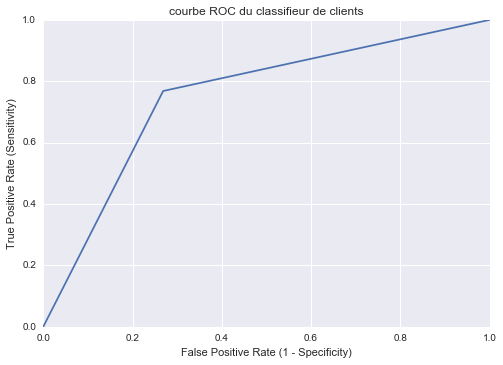

In [415]:
Model= eclf
seuil= 0.19

print "Resultat de validation (sans seuil) : ",validation(Model, XValid, YValid)

# on stocke les degrés d'appartenance pour la classe 1
yValid_pred_prob = Model.predict_proba(XValid)[:, 1]

# Predire un client mécontent si la probabilité prédite est supérieure à le seuil
yValid_pred_class = np.array(yValid_pred_prob>seuil, dtype=int)

fpr, tpr, thresholds = metrics.roc_curve(YValid, yValid_pred_class)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('courbe ROC du classifieur de clients')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print "roc_auc_score (avec seuil = ",seuil,") = ", metrics.roc_auc_score(YValid, yValid_pred_class)


# nouvelle matrice de confusion (avec seuil)
matCorr = metrics.confusion_matrix(YValid, yValid_pred_class)

TP = matCorr[1, 1]
TN = matCorr[0, 0]
FP = matCorr[0, 1]
FN = matCorr[1, 0]

print "\n\n Matrice de confusion\n",matCorr

# la sensitivity a augmenté
print"\nSensibilité = ", TP / float(TP + FN)

# la spécificité a diminué
print"Spécificité ", TN / float(TN + FP)

<br/><br/><br/>
## Bagging Classifier + KNeighborsClassifier

In [401]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
modele_5 = BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5, n_estimators=15, n_jobs=2, random_state=1)
modele_5.fit(X_train[RandomForestSelection],Y_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=0.5, n_estimators=15, n_jobs=2, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

In [402]:
print "Validation = ",validation(modele_5, X_test[RandomForestSelection], Y_test)

Validation =  0.71583125246


### Resultat d'analyse

Matrice de Confusion
       0  1
0  14620  0
1    584  0


Taux de prédiction (accuracy):  0.961589055512
Sensibilité :  0.0
Precision : nan
Spécificité : 1.0 

roc_auc_score =  0.71583125246


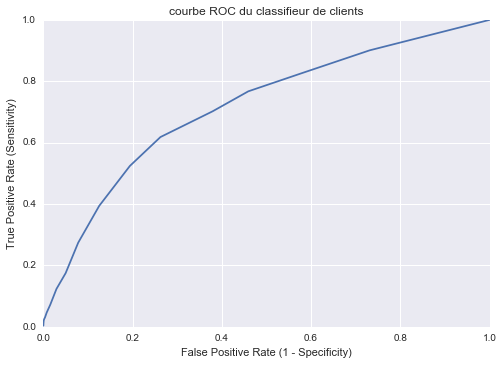

In [403]:
Model=modele_5

# On prédit pour les données de test
y_pred_class = Model.predict(X_test[RandomForestSelection])

# on stocke la matrice de confusion et on récupère les TP, TN, FP, FN
confusion = metrics.confusion_matrix(Y_test, y_pred_class)

tp = confusion[1, 1]
tn = confusion[0, 0]
fp = confusion[0, 1]
fn = confusion[1, 0]

print "Matrice de Confusion"
matrix = pd.DataFrame([confusion[0][0],confusion[1][0]])
matrix['1'] = [confusion[0][1],confusion[1][1]]
print  matrix

print "\n\nTaux de prédiction (accuracy): ",(tp + tn) / float(tp + tn + fp + fn)
print "Sensibilité : ",tp / float(tp + fn)
print"Precision :", tp / float(tp + fp)
print"Spécificité :", tn / float(tn + fp),"\n"

# on stocke les degrés d'appartenance pour la classe 1
y_pred_prob = Model.predict_proba(X_test[RandomForestSelection])[:, 1]


fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('courbe ROC du classifieur de clients')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print "roc_auc_score = ", metrics.roc_auc_score(Y_test, y_pred_prob)

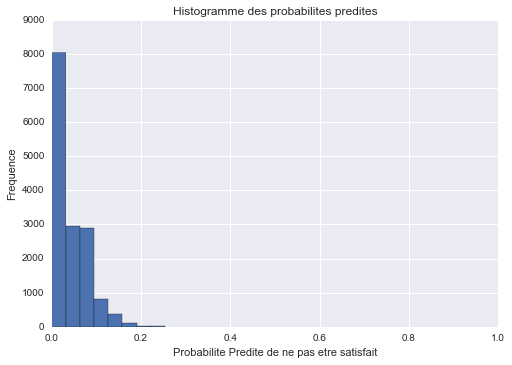

In [404]:
# histogramme des probabilités prédites
plt.hist(y_pred_prob, bins=8)
plt.xlim(0, 1)
plt.title('Histogramme des probabilites predites')
plt.xlabel('Probabilite Predite de ne pas etre satisfait' )
plt.ylabel('Frequence')

### Resultat avec le seuil choisi

Resultat de validation (sans seuil) :  0.71583125246
roc_auc_score (avec seuil =  0.05 ) =  0.661287315181


 Matrice de confusion
[[9072 5548]
 [ 174  410]]

Sensibilité =  0.702054794521
Spécificité  0.620519835841


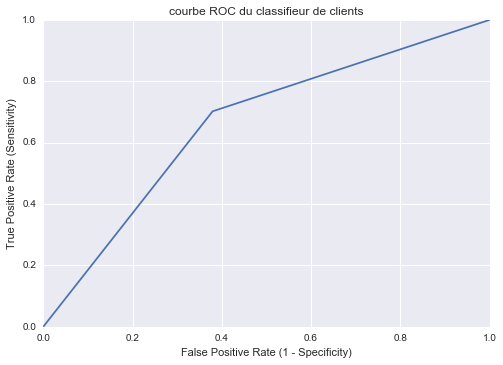

In [405]:
Model= modele_5
seuil= 0.05

print "Resultat de validation (sans seuil) : ",validation(Model, X_test[RandomForestSelection], Y_test)

# on stocke les degrés d'appartenance pour la classe 1
yTest_pred_prob = Model.predict_proba(X_test[RandomForestSelection])[:, 1]

# Predire un client mécontent si la probabilité prédite est supérieure à le seuil
yTest_pred_class = np.array(yTest_pred_prob>seuil, dtype=int)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, yTest_pred_class)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('courbe ROC du classifieur de clients')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print "roc_auc_score (avec seuil = ",seuil,") = ", metrics.roc_auc_score(Y_test, yTest_pred_class)


# nouvelle matrice de confusion (avec seuil)
matCorr = metrics.confusion_matrix(Y_test, yTest_pred_class)

TP = matCorr[1, 1]
TN = matCorr[0, 0]
FP = matCorr[0, 1]
FN = matCorr[1, 0]

print "\n\n Matrice de confusion\n",matCorr

# la sensitivity a augmenté
print"\nSensibilité = ", TP / float(TP + FN)

# la spécificité a diminué
print"Spécificité ", TN / float(TN + FP)

## SVC Model

In [428]:
from sklearn.svm import LinearSVC, SVC

modele_6 = SVC(C=0.1, gamma=0.1, random_state=1, probability=True)
modele_6.fit(X_train[RandomForestSelection],Y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
  verbose=False)

In [429]:
print "Validation = ",validation(modele_6, X_test[RandomForestSelection], Y_test)

Validation =  0.511791468339


### Resultat d'analyse

Matrice de Confusion
       0  1
0  14620  0
1    584  0


Taux de prédiction (accuracy):  0.961589055512
Sensibilité :  0.0
Precision : nan
Spécificité : 1.0 

roc_auc_score =  0.511791468339


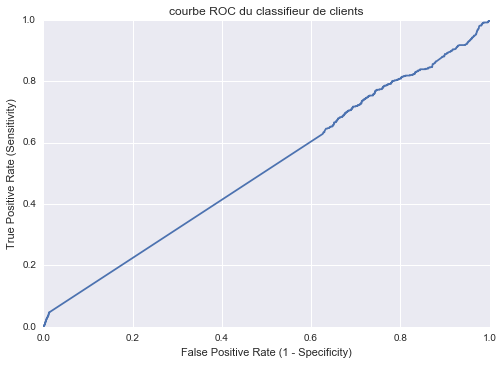

In [430]:
Model=modele_6

# On prédit pour les données de test
y_pred_class = Model.predict(X_test[RandomForestSelection])

# on stocke la matrice de confusion et on récupère les TP, TN, FP, FN
confusion = metrics.confusion_matrix(Y_test, y_pred_class)

tp = confusion[1, 1]
tn = confusion[0, 0]
fp = confusion[0, 1]
fn = confusion[1, 0]

print "Matrice de Confusion"
matrix = pd.DataFrame([confusion[0][0],confusion[1][0]])
matrix['1'] = [confusion[0][1],confusion[1][1]]
print  matrix

print "\n\nTaux de prédiction (accuracy): ",(tp + tn) / float(tp + tn + fp + fn)
print "Sensibilité : ",tp / float(tp + fn)
print"Precision :", tp / float(tp + fp)
print"Spécificité :", tn / float(tn + fp),"\n"

# on stocke les degrés d'appartenance pour la classe 1
y_pred_prob = Model.predict_proba(X_test[RandomForestSelection])[:, 1]


fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('courbe ROC du classifieur de clients')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print "roc_auc_score = ", metrics.roc_auc_score(Y_test, y_pred_prob)

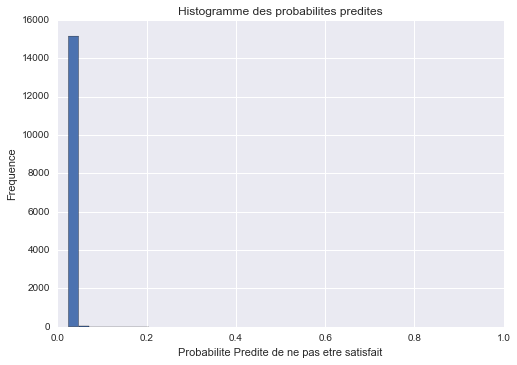

In [431]:
# histogramme des probabilités prédites
plt.hist(y_pred_prob, bins=8)
plt.xlim(0, 1)
plt.title('Histogramme des probabilites predites')
plt.xlabel('Probabilite Predite de ne pas etre satisfait' )
plt.ylabel('Frequence')

### Resultat avec le seuil choisi

Resultat de validation (sans seuil) :  0.511791468339
roc_auc_score (avec seuil =  0.04 ) =  0.508337471656


 Matrice de confusion
[[ 3323 11297]
 [  123   461]]

Sensibilité =  0.789383561644
Spécificité  0.227291381669


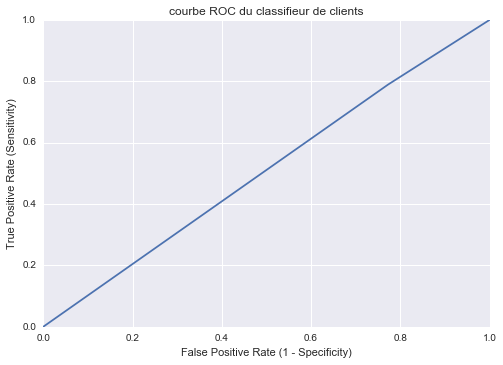

In [440]:
Model= modele_6
seuil= 0.04

print "Resultat de validation (sans seuil) : ",validation(Model, X_test[RandomForestSelection], Y_test)

# on stocke les degrés d'appartenance pour la classe 1
yTest_pred_prob = Model.predict_proba(X_test[RandomForestSelection])[:, 1]

# Predire un client mécontent si la probabilité prédite est supérieure à le seuil
yTest_pred_class = np.array(yTest_pred_prob>seuil, dtype=int)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, yTest_pred_class)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('courbe ROC du classifieur de clients')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print "roc_auc_score (avec seuil = ",seuil,") = ", metrics.roc_auc_score(Y_test, yTest_pred_class)


# nouvelle matrice de confusion (avec seuil)
matCorr = metrics.confusion_matrix(Y_test, yTest_pred_class)

TP = matCorr[1, 1]
TN = matCorr[0, 0]
FP = matCorr[0, 1]
FN = matCorr[1, 0]

print "\n\n Matrice de confusion\n",matCorr

# la sensitivity a augmenté
print"\nSensibilité = ", TP / float(TP + FN)

# la spécificité a diminué
print"Spécificité ", TN / float(TN + FP)